# Custom Window Generation

In this notebook, we will:

1. **Create interval windows for custom events**
    1. Eclipse windows
    2. AOI intersection

In [1]:
import plotly.express as px
import pandas as pd

from ostk.mathematics.geometry.d2.object import Point as Point2d
from ostk.mathematics.geometry.d2.object import Polygon as Polygon2d
from ostk.mathematics.curve_fitting import Interpolator

from ostk.physics.environment.object.celestial import Earth
from ostk.physics.environment.object.celestial import Sun
from ostk.physics.environment.gravitational import Earth as EarthGravitationalModel
from ostk.physics.environment.atmospheric import Earth as EarthAtmosphericModel
from ostk.physics.environment.magnetic import Earth as EarthMagneticModel
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.coordinate import Frame
from ostk.physics.coordinate import Position
from ostk.physics.coordinate import Velocity
from ostk.physics import Environment
from ostk.physics.coordinate.spherical import LLA

from ostk.astrodynamics.solver import TemporalConditionSolver
from ostk.astrodynamics.trajectory.orbit.model import Tabulated
from ostk.astrodynamics.trajectory.state import NumericalSolver
from ostk.astrodynamics.trajectory import State
from ostk.astrodynamics.trajectory import Propagator

Setup an initial state

In [2]:
start_instant = Instant.J2000()
initial_state = State(
    instant=start_instant,
    position=Position.meters([7000000.0, 0.0, 0.0], Frame.GCRF()),
    velocity=Velocity.meters_per_second(
        [0.0, 5335.865450622126, 5335.865450622126], Frame.GCRF()
    ),
)

analysis_interval = Interval.closed(
    start_instant=initial_state.get_instant(),
    end_instant=initial_state.get_instant() + Duration.days(2.0),
)

### Window generation
To create windows we must first
- generate a state provider, like
  - a tabulated model made from propagated states (ideal)
  - a propagated model
  - a kepler model
  - etc.
- define your condition that accepts an Instant and returns a boolean

#### Create a model
Here, we create a tabulated model by propagating states till the end of your analysis interval

In [3]:
earth = Earth.from_models(
    gravity_model=EarthGravitationalModel(EarthGravitationalModel.Type.Spherical),
    magnetic_model=EarthMagneticModel(EarthMagneticModel.Type.Undefined),
    atmospheric_model=EarthAtmosphericModel(EarthAtmosphericModel.Type.Undefined),
)
environment = Environment(
    instant=Instant.J2000(),
    objects=[earth, Sun.default()],
)

In [4]:
propagator = Propagator.from_environment(
    numerical_solver=NumericalSolver.default_conditional(),
    environment=environment,
)

In [5]:
propagator.calculate_state_at(
    state=initial_state,
    instant=analysis_interval.get_end(),
)
tabulated = Tabulated(
    states=propagator.access_numerical_solver().get_observed_states()[1:],
    initial_revolution_number=0,
    interpolation_type=Interpolator.Type.BarycentricRational,
)

#### Define our solver

In [6]:
solver = TemporalConditionSolver(
    time_step=Duration.seconds(10.0),
    tolerance=Duration.milliseconds(1.0),
)

#### Define our condition
Eclipse condition

In [7]:
def eclipse_condition(instant):
    state = tabulated.calculate_state_at(instant)
    environment.set_instant(state.get_instant())

    return environment.is_position_in_eclipse(state.get_position())

In [8]:
eclipse_windows = solver.solve(condition=eclipse_condition, interval=analysis_interval)
print(*eclipse_windows[:3])

-- Interval ----------------------------------------------------------------------------------------
    Start:                                   2000-01-01 12:08:56.098.124.727 [UTC]    
    End:                                     2000-01-01 12:43:31.178.679.568 [UTC]    
----------------------------------------------------------------------------------------------------
 -- Interval ----------------------------------------------------------------------------------------
    Start:                                   2000-01-01 13:46:05.792.231.519 [UTC]    
    End:                                     2000-01-01 14:20:40.902.549.922 [UTC]    
----------------------------------------------------------------------------------------------------
 -- Interval ----------------------------------------------------------------------------------------
    Start:                                   2000-01-01 15:23:15.484.906.855 [UTC]    
    End:                                     2000-01-01 15

Imaging AOI intersection

In [9]:
AOI = [
    [59.163411994221235, 52.03687119546126],
    [59.163411994221235, 34.16890408047914],
    [121.33841912739558, 34.16890408047914],
    [121.33841912739558, 52.03687119546126],
    [59.163411994221235, 52.03687119546126],
]

target_geometry = Polygon2d(
    [Point2d(float(coordinates[0]), float(coordinates[1])) for coordinates in AOI]
)

In [10]:
def aoi_intersection_condition(instant):
    state = tabulated.calculate_state_at(instant)
    lla = LLA.cartesian(
        cartesian_coordinates=state.get_position().get_coordinates(),
        ellipsoid_equatorial_radius=EarthGravitationalModel.EGM2008.equatorial_radius,
        ellipsoid_flattening=EarthGravitationalModel.EGM2008.flattening,
    )
    point = Point2d(lla.get_longitude().in_degrees(), lla.get_latitude().in_degrees())

    return target_geometry.contains(point)

In [11]:
imaging_windows = solver.solve(
    condition=aoi_intersection_condition, interval=analysis_interval
)

In [12]:
print(*imaging_windows[:5])

-- Interval ----------------------------------------------------------------------------------------
    Start:                                   2000-01-01 12:17:02.410.496.646 [UTC]    
    End:                                     2000-01-01 12:29:30.108.716.099 [UTC]    
----------------------------------------------------------------------------------------------------
 -- Interval ----------------------------------------------------------------------------------------
    Start:                                   2000-01-01 13:54:10.927.731.242 [UTC]    
    End:                                     2000-01-01 14:06:38.626.071.132 [UTC]    
----------------------------------------------------------------------------------------------------
 -- Interval ----------------------------------------------------------------------------------------
    Start:                                   2000-01-01 15:31:19.444.465.902 [UTC]    
    End:                                     2000-01-01 15

In [13]:
def get_nadir_track(window, time_step=Duration.seconds(15.0)):
    instants = window.generate_grid(time_step)
    states = tabulated.calculate_states_at(instants)
    llas = []
    for state in states:
        lla = LLA.cartesian(
            state.get_position().get_coordinates(),
            EarthGravitationalModel.EGM2008.equatorial_radius,
            EarthGravitationalModel.EGM2008.flattening,
        )
        llas.append(
            {
                "lon": float(lla.get_longitude().in_degrees()),
                "lat": float(lla.get_latitude().in_degrees()),
            }
        )

    return llas

In [14]:
geodetic_coordinates = get_nadir_track(imaging_windows[0])

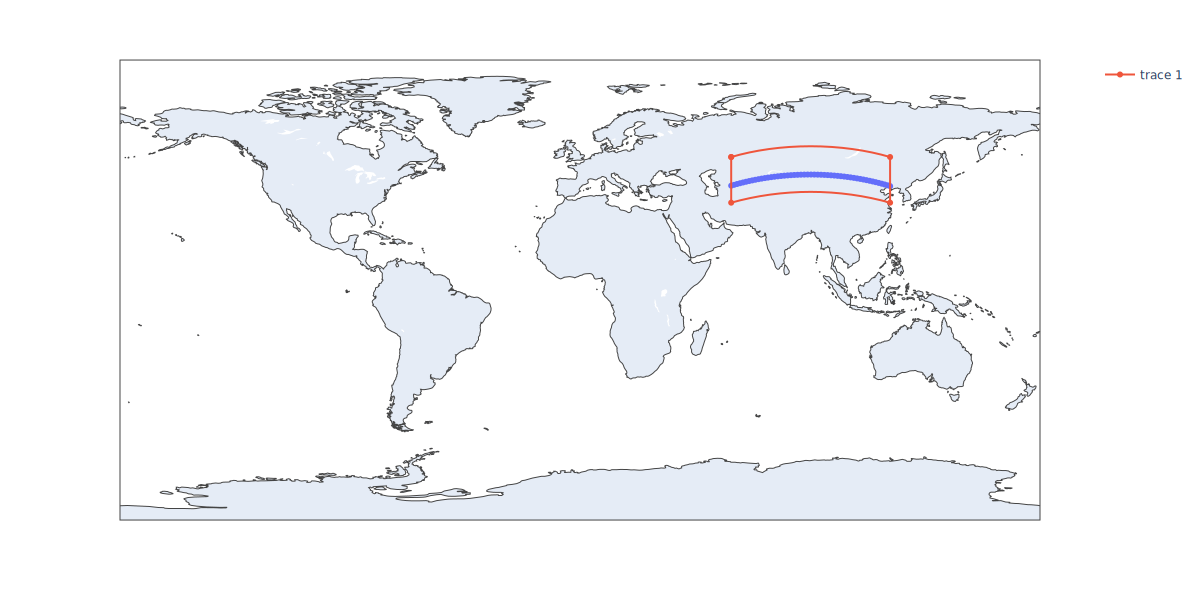

In [15]:
figure = px.scatter_geo(
    pd.DataFrame(geodetic_coordinates),
    lon="lon",
    lat="lat",
    height=600,
    width=1200,
)

figure.add_scattergeo(
    lon=[float(line.x()) for line in target_geometry.get_outer_ring()],
    lat=[float(line.y()) for line in target_geometry.get_outer_ring()],
    mode="markers+lines",
)
figure.show("svg")

---